In [1]:
from util import * 
import matplotlib.pyplot as plt 

Corrcoef: 0.9324


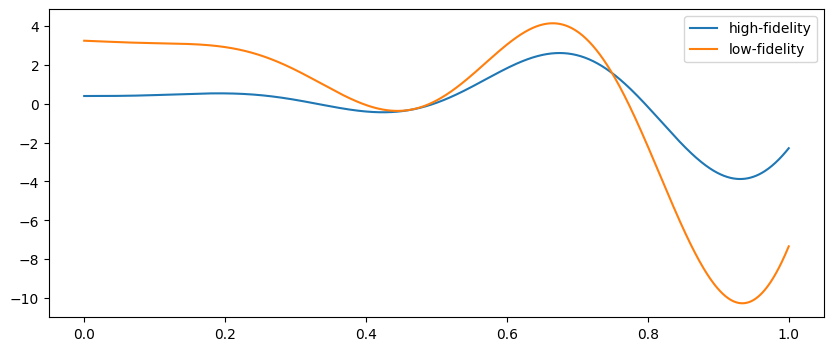

In [2]:
# # LINEAR-B 
funcs = [
    lambda x: ((5*x**2) * np.sin(12*x))+0.39071933219615607, 
    lambda x: (2*(5*x**2) * np.sin(12*x)+(x**3-0.5*np.sin(3*x-0.5))+4*np.cos(2*x))-1.0072174840335937]

# Assigning sample sizes
N_hi, N_lo, N_test = 5, 1000, 1000 
# Assigning computational budgets 
C_hi, C_lo = 5, 1 
X_hi = np.random.uniform(0,1.0, N_hi)
X_lo = np.random.uniform(0,1.0, N_lo)
X_test = np.linspace(0,1.0, N_test)

Y_hi = funcs[0](X_hi) - np.mean(funcs[0](X_test))
Y_lo = funcs[1](X_lo) - np.mean(funcs[1](X_test))

corr_coef = np.corrcoef(funcs[0](X_test), funcs[1](X_test))[0,1]

print("Corrcoef: %.4f" % corr_coef)

plt.figure(figsize=(10,4))
plt.plot(X_test, funcs[0](X_test), label = "high-fidelity")
plt.plot(X_test, funcs[1](X_test), label = "low-fidelity")
plt.legend()

In [3]:
np.mean(funcs[0](X_test)), np.mean(funcs[1](X_test))

(np.float64(4.263256414560601e-17), np.float64(5.684341886080802e-16))

In [ ]:
g1 = GP(
    X_lo.reshape(-1,1),
    funcs[1](X_lo), 
    RBF, 
    Linear, 
    max_cond = 1e8,
    noise_var = 1e-7, 
    epsilon = 1e-12,
    calibrate=True
)

# g1.set_params(
#     {'noise_var': jnp.array(-27.63093222), 
#      'k_param':   jnp.array([45.18417054, -2.55169638]),
#      'm_param':   jnp.array([1.31050888, 6.8476559 ])}
# )

183860984773.46555
18384.938168630346
9.999368920645324e-08
Calibrated white noise variance: 1.8375e-04


In [5]:
g1.p

{'noise_var': Array(1.60434895, dtype=float64),
 'k_param': Array([17.95160078, 37.39321705], dtype=float64),
 'm_param': Array([  5.26886185, -10.42418788], dtype=float64)}

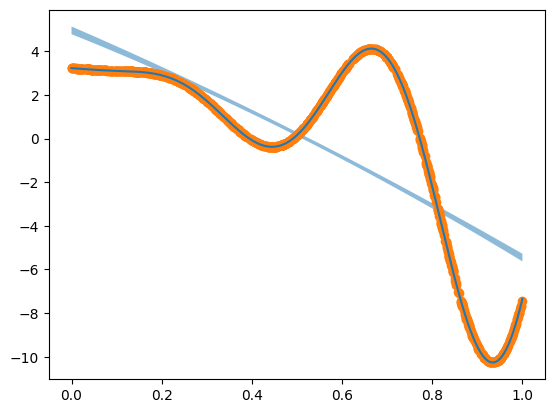

In [6]:
mean, var = g1.predict(X_test.reshape(-1,1), full_cov = False)
conf = 2 * np.sqrt(var)

plt.plot(X_test, funcs[1](X_test), label = "low-fidelity")
plt.fill_between(X_test, mean - conf, mean + conf, alpha = 0.5)
plt.scatter(X_lo, funcs[1](X_lo))

In [7]:
g0 = DeltaGP(
    X_hi.reshape(-1,1),
    funcs[0](X_hi), 
    funcs[1](X_hi), 
    RBF, 
    Zero, 
    noise_var = 1e-8, 
    epsilon = 1e-8, 
    max_cond = 1e6
)

g0.set_params(
    {'noise_var': jnp.array(-11.44789151), 
    'k_param':    jnp.array([3.11076541, 1.32966874]),
    'm_param':    jnp.array([0.]), 
    'rho':        jnp.array(0.49973393)}
)

# g0.set_params(
#     {'noise_var': jnp.array(-11.44789151), 
#     'k_param':    jnp.array([3.11076541, 1.32966874]),
#     'm_param':    jnp.array([0.]), 
#     'rho':        corr_coef * np.sqrt(np.var(funcs[0](X_test)) / np.var(funcs[1](X_test)))}
# )

Calibrated white noise variance: 4.9879e-05


In [ ]:
optimizer = ADAM(g0, delta_neg_mll, beta1=0.9, beta2=0.99)
optimizer.run(1e-2, 5000, ['k_param', 'rho'])

  1%|          | 46/5000 [00:00<00:25, 194.95it/s, Loss: -5.4942e+00]

In [ ]:
kr = GP(
    X_hi.reshape(-1,1),
    funcs[0](X_hi), 
    RBF, 
    Linear, 
    noise_var = 1e-8, 
    epsilon = 1e-8, 
    max_cond = 1e8
)
kr.set_params(
    {'noise_var':jnp.array(-13.46455067),
    'k_param':   jnp.array([ 8.77047402, -2.59487462]),
    'm_param':   jnp.array([-1.13692191,  5.07544546])}
) 
# optimizer = ADAM(kr, neg_mll, beta1 = 0.9, beta2 = 0.999)
# optimizer.run(lr = 1e-3, epochs = 25000, params = ['k_param', 'm_param'])

Calibrated white noise variance: 2.8531e-08


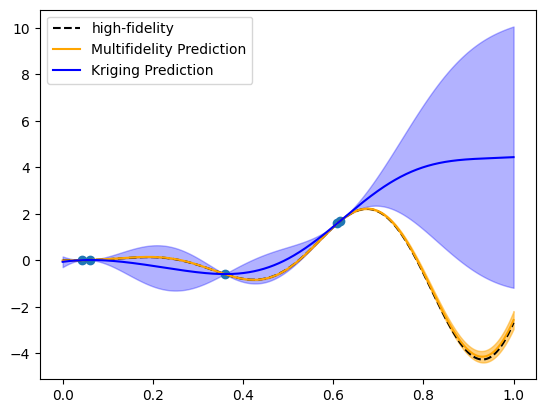

In [ ]:
delta_mean, delta_var = g0.predict(X_test.reshape(-1,1), full_cov = False)
lo_mean, lo_var = g1.predict(X_test.reshape(-1,1), full_cov = False)
rho = g0.p['rho']

mean = rho * lo_mean + delta_mean 
var = rho**2 * lo_var + delta_var 
conf = 2 * np.sqrt(var)

kr_mean, kr_var = kr.predict(X_test.reshape(-1,1), full_cov = False)
kr_conf = 2 * np.sqrt(kr_var)

plt.plot(X_test, funcs[0](X_test), label = "high-fidelity", color = 'black', linestyle = 'dashed')
plt.plot(X_test, mean, color = 'orange', label = "Multifidelity Prediction")
plt.fill_between(X_test, mean - conf, mean + conf, alpha = 0.5, color = 'orange')
plt.plot(X_test, kr_mean, color = 'blue', label = "Kriging Prediction")
plt.fill_between(X_test, kr_mean - kr_conf, kr_mean + kr_conf, alpha = 0.3, color = 'blue')
plt.scatter(X_hi, funcs[0](X_hi))
plt.legend()

In [ ]:
print("Multifidelity: %.4e" % np.mean(var + (mean - funcs[0](X_test))**2))
print("Kriging:       %.4e" % np.mean(var + (kr_mean - funcs[0](X_test))**2))

Multifidelity: 4.9593e-03
Kriging:       1.2229e+01


In [ ]:
def get_mse(key, g0, g1, N_hi, N_lo, X_test):
    # Generating random samples 
    key_hi, key_lo = jax.random.split(key, 2)
    X_hi = jax.random.uniform(key_hi, (N_hi,))
    X_lo = jax.random.uniform(key_lo, (N_lo,))

    # Setting training data 
    g0.X, g0.Y1, g0.Y2 = X_hi.reshape(-1,1), funcs[0](np.array(jax.device_get(X_hi))), funcs[1](np.array(jax.device_get(X_hi)))
    g0.set_params(g0.p)

    g1.X, g1.Y = X_lo.reshape(-1,1), funcs[1](X_lo)
    g1.set_params(g1.p)

    # Making predictions
    delta_mean, delta_var = g0.predict(X_test.reshape(-1,1), full_cov = False)
    lo_mean, lo_var = g1.predict(X_test.reshape(-1,1), full_cov = False)
    rho = g0.p['rho']

    # Computing posterior mean and variance 
    mean = rho * lo_mean + delta_mean 
    var = rho**2 * lo_var + delta_var 

    # Returning Mean squared error of predictions 
    return jnp.mean(var + (mean - funcs[0](X_test))**2)

    

def avg_mse(N_hi, budget, g0, g1, N_mc, C_hi, C_lo, X_test): 
    # Number of low-fidelity samples 
    N_lo = int((budget - N_hi * C_hi) / C_lo)
    print(N_lo)

    key = jax.random.key(42)
    rng_keys = jax.random.split(key, N_mc)

    mses = np.zeros(N_mc)

    for i, key in enumerate(rng_keys):
        mses[i] = get_mse(key, g0, g1, N_hi, N_lo, X_test)

    return [jnp.mean(mses), 2*jnp.std(mses)]


budget, N_mc = 100, 25

N_hi_min, N_hi_max = 2, int(budget / C_hi)

N_his = jnp.arange(N_hi_min, N_hi_max+1)


results = jnp.array([
    avg_mse(int(N_hi), budget, g0, g1, N_mc, C_hi, C_lo, X_test)
    for N_hi in N_his
])

90
85
80
75
70
65
60
55
50
45
40
35
30
25
20
15
10
5
0


In [ ]:
# MFMC Budget Allocation for two levels of fidelity
c11, c22, c12 = np.var(funcs[0](X_test)), np.var(funcs[1](X_test)), np.cov(np.vstack((funcs[0](X_test).reshape(1,-1), funcs[1](X_test).reshape(1,-1))))[0,1]
alpha = c12 / c22 
ratio = np.sqrt(C_hi  / C_lo * corr_coef**2 / (1 - corr_coef**2))

N_hi_opt = budget / (C_lo * ratio + C_hi)
N_lo_opt = ratio * N_hi_opt 
N_hi_opt, N_lo_opt

(np.float64(9.287596892973358), np.float64(53.562015535133206))

In [ ]:
# Self-derived budget allocation 
c11, c22, c12 = np.var(funcs[0](X_test)), np.var(funcs[1](X_test)), np.cov(np.vstack((funcs[0](X_test).reshape(1,-1), funcs[1](X_test).reshape(1,-1))))[0,1]
a, b = c11, c12**2 / c22 

N_hi_opt = budget * (C_hi * (a-b) - np.sqrt(b * C_hi * C_lo * (a-b))) / (C_hi * (C_hi * (a-b) - b * C_lo))
N_lo_opt = (budget - N_hi_opt * C_hi) / C_lo
N_hi_opt, N_lo_opt

(np.float64(9.249267994765653), np.float64(53.75366002617174))

In [ ]:
# Budget allocation using Kennedy O'Hagan alpha value
new_corr_coef = g0.p['rho'] * np.sqrt(c22 / c11)
ratio = np.sqrt(C_hi  / C_lo * new_corr_coef / (1 - new_corr_coef**2))

N_hi_opt = budget / (C_lo * ratio + C_hi)
N_lo_opt = ratio * N_hi_opt 
N_hi_opt, N_lo_opt

/tmp/ipykernel_5916/3581605291.py:3: RuntimeWarning: invalid value encountered in sqrt
  ratio = np.sqrt(C_hi  / C_lo * new_corr_coef**2 / (1 - new_corr_coef**2))


(np.float64(nan), np.float64(nan))

In [ ]:
g0.p['rho'] * c22 / c11

Array(3.31409338, dtype=float64)

In [ ]:
np.std(funcs[0](X_test))

np.float64(1.6653580450336574)

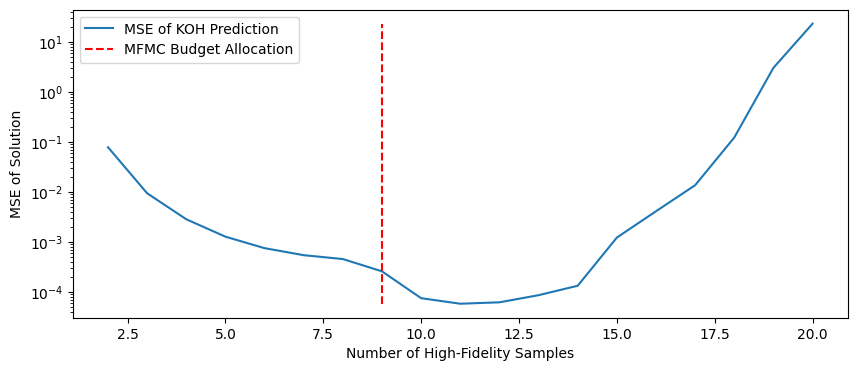

In [ ]:
plt.figure(figsize=(10,4))
plt.semilogy(N_his, results[:,0], label = "MSE of KOH Prediction")
# plt.fill_between(N_his, results[:,0] - results[:,1], results[:,0] + results[:,1], alpha = 0.3, color = 'blue', label = 'two-sigma')
plt.plot([np.round(N_hi_opt), np.round(N_hi_opt)], [min(results[:,0]), max(results[:,0])], label = "MFMC Budget Allocation", color = 'red', linestyle = 'dashed')
plt.xlabel("Number of High-Fidelity Samples")
plt.ylabel("MSE of Solution")
plt.legend()
